In [2]:
import os
import tensorflow as tf

# Configurar memoria para evitar asignación completa
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Verificar dispositivos disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Permitir crecimiento de memoria en la GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)
tf.config.optimizer.set_jit(True)

2025-03-26 20:12:07.824442: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 20:12:07.966814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743016328.027209     772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743016328.046197     772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 20:12:08.192766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

GPU configurada correctamente.


## 2. Implementation

## 2.1 UseCase 1 : Image Reconstruction

1. Load the required libraries


In [3]:
## load the libraries 
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, BatchNormalization, Activation, Cropping2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

### 2. Dataset Prepration 

Load the dataset, separate predictors and target, normalize the inputs.

In [4]:
import pandas as pd### read dataset 

train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

### 3. Create Autoencoder architecture

In this section, lets create an autoencoder architecture. The encoding part comprises of three layers with 2000, 1200, and 500 nodes. Encoding architecture is connected to latent view space comprising of 10 nodes which is then connected to decoding architecture with 500, 1200, and 2000 nodes. The final layer comprises of exact number of nodes as the input layer.

In [5]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

I0000 00:00:1743016333.918524     772 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Here is the summary of our autoencoder architecture.

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │     1,177,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │         5,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1000)           │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1500)           │     1,501,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │     1,176,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,368,794 (24.30 MB)

 Trainable params: 6,368,794 (24.30 MB)

 Non-trainable params: 0 (0.00 B)

Next, we will train the model with early stopping callback.

In [7]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1743016335.250745    1049 service.cc:148] XLA service 0x7f90880040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743016335.250961    1049 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
I0000 00:00:1743016335.259020    1049 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1743016335.287599    1049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-26 20:12:15.653176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-26 20:12:16.281702: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 44 bytes spill stores, 44 bytes spill loads

2025-03-26 20:12:16.342540: I external/l

20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1310

2025-03-26 20:12:26.227658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 48 bytes spill stores, 48 bytes spill loads

2025-03-26 20:12:26.421177: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 36 bytes spill stores, 40 bytes spill loads

2025-03-26 20:12:26.447022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 212 bytes spill stores, 212 bytes spill loads

2025-03-26 20:12:26.494755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292_0', 768 bytes spill stores, 720 bytes spill loads

2025-03-26 20:12:26.554322: I external/local_xla/xla/strea

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 0.1252

2025-03-26 20:12:36.710371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 212 bytes spill stores, 212 bytes spill loads

2025-03-26 20:12:36.776321: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 304 bytes spill stores, 304 bytes spill loads

2025-03-26 20:12:37.024354: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32_0', 1036 bytes spill stores, 724 bytes spill loads

2025-03-26 20:12:37.091397: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 4 bytes spill stores, 4 bytes spill loads

2025-03-26 20:12:37.094308: I external/local_xla/xla/stream_e

24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 692ms/step - loss: 0.1240 - val_loss: 0.0714
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0666 - val_loss: 0.0503
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0471 - val_loss: 0.0402
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0393 - val_loss: 0.0398
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0382 - val_loss: 0.0335
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0327 - val_loss: 0.0310
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0305 - val_loss: 0.0282
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0283 - val_loss: 0.0264
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0258 - val_loss: 0.0251
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.0244
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - val

Generate the predictions on validation data. 

In [8]:
preds = model.predict(val_x)

2025-03-26 20:12:47.286879: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 212 bytes spill stores, 212 bytes spill loads

2025-03-26 20:12:47.594917: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 364 bytes spill stores, 396 bytes spill loads

2025-03-26 20:12:47.685458: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 236 bytes spill stores, 236 bytes spill loads

2025-03-26 20:12:47.730360: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 364 bytes spill stores, 396 bytes spill loads

2025-03-26 20:12:47.795492: I external/local_xla/xla/stream_

375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 849us/step


Lets plot the original and predicted image

**Inputs: Actual Images**

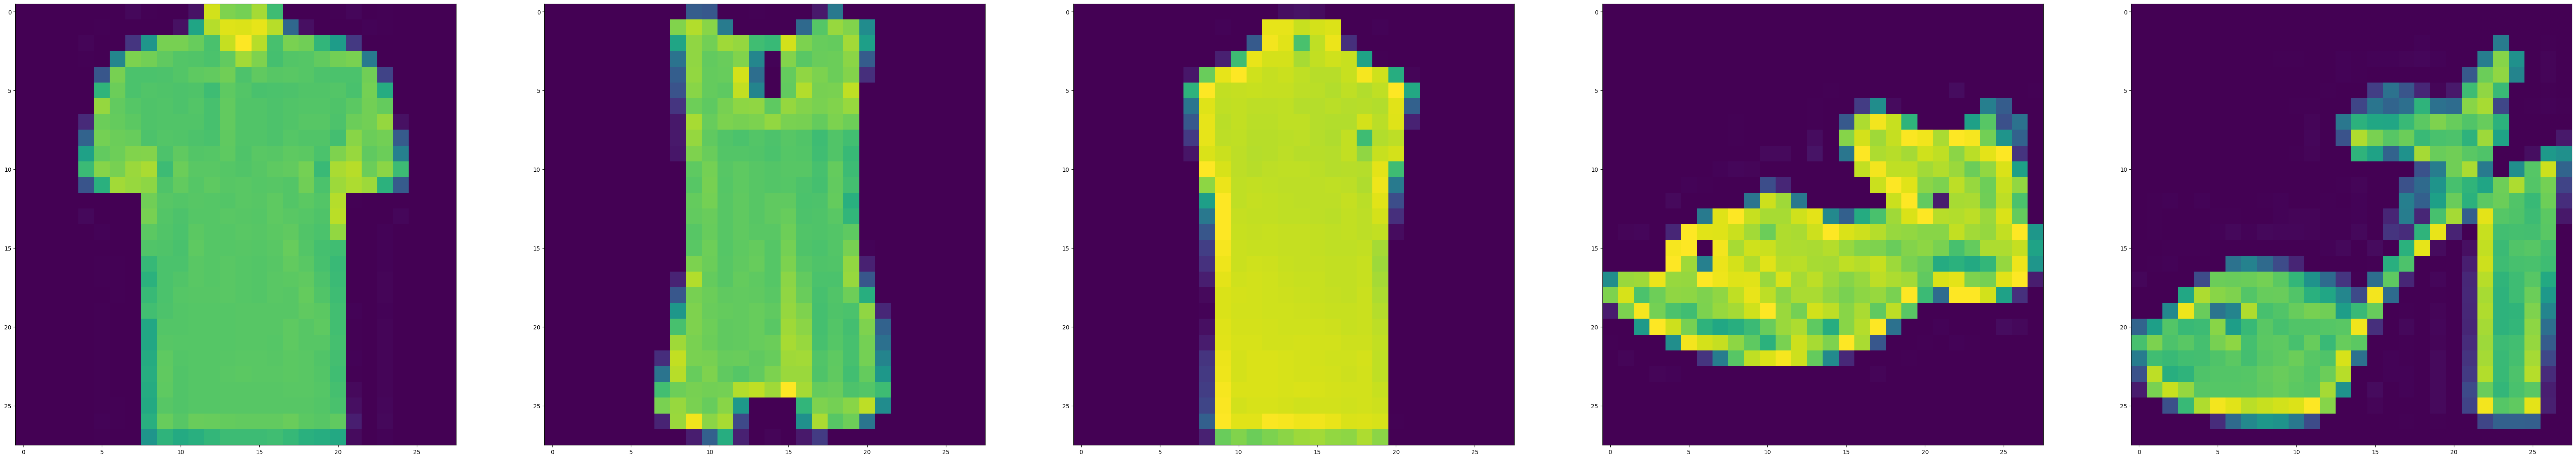

In [9]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

**Predicted : Autoencoder Output**

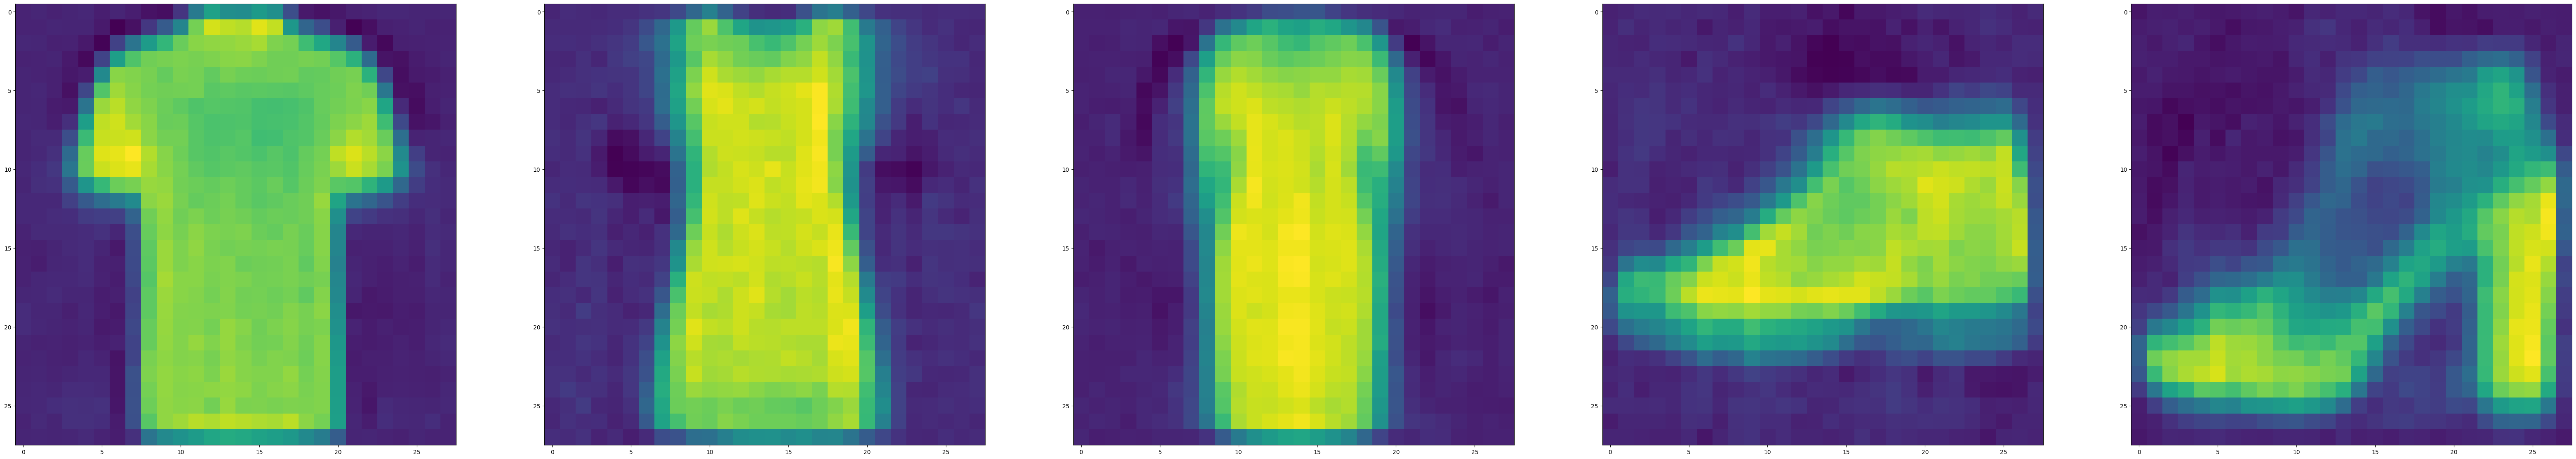

In [10]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

So we can see that an autoencoder trained with 20 epoochs is able to reconstruct the input images very well. Lets look at other use-case of autoencoders - Image denoising or removal of noise from the image.  

## 2.2 UseCase 2 - Image Denoising

Autoencoders are pretty useful, lets look at another application of autoencoders - Image denoising. Many a times input images contain noise in the data, autoencoders can be used to get rid of those images. Lets see it in action. First lets prepare the train_x and val_x data contianing the image pixels. 

In [11]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In this autoencoder network, we will add convolutional layers because convolutional networks works really well with the image inputs. To apply convolutions on image data, we will reshape our inputs in the form of 28 * 28 matrix. For more information related to CNN,  refer to my previous [kernel](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn).  

In [12]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Noisy Images 

We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example: 

- Salt and Pepper Noise  
- Gaussian Noise  
- Periodic Noise  
- Speckle Noise  

Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels. 

Thanks to @ColinMorris for suggesting the correction in salt and pepper noise.

In [13]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

Before adding noise

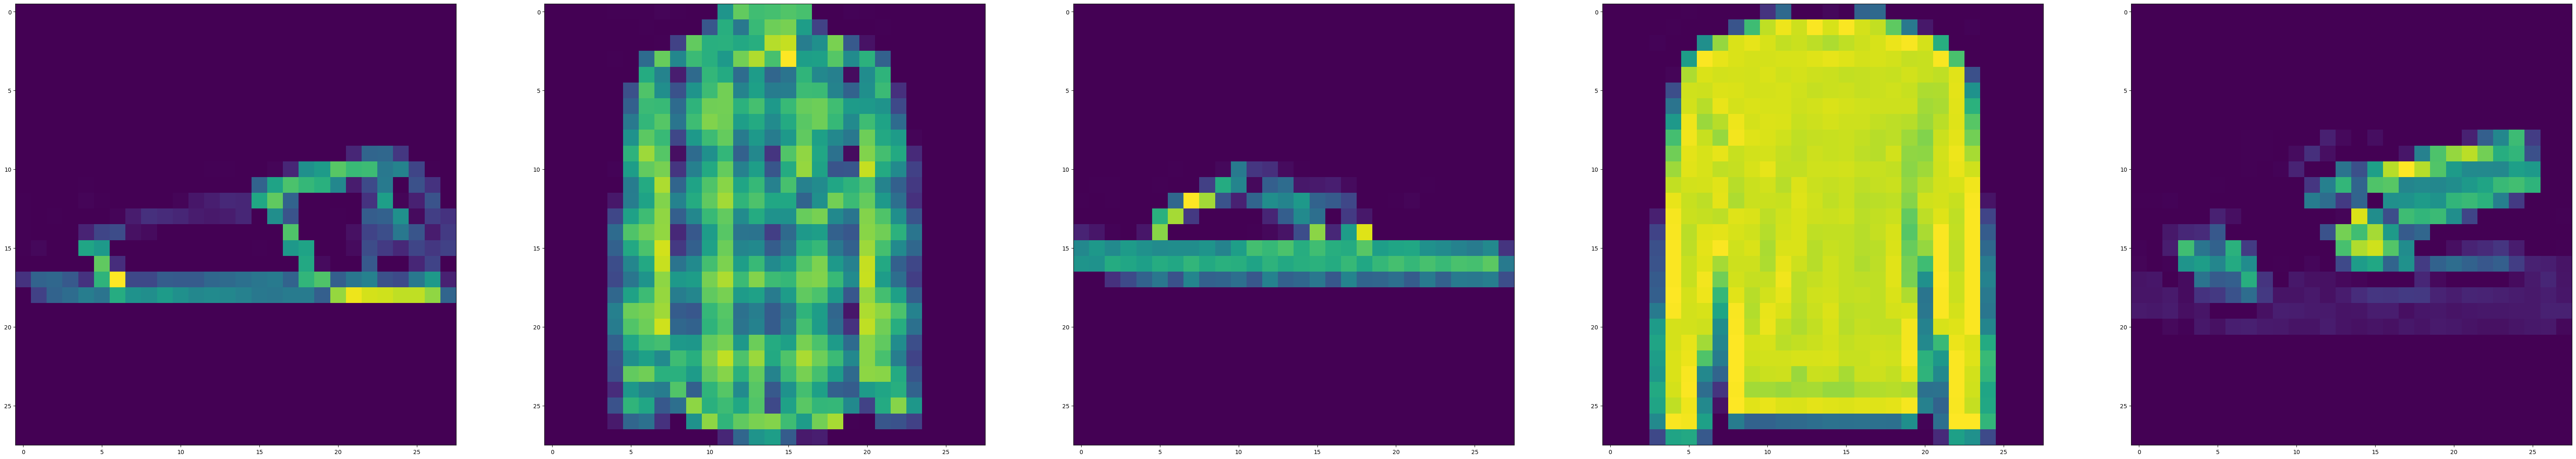

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

After adding noise

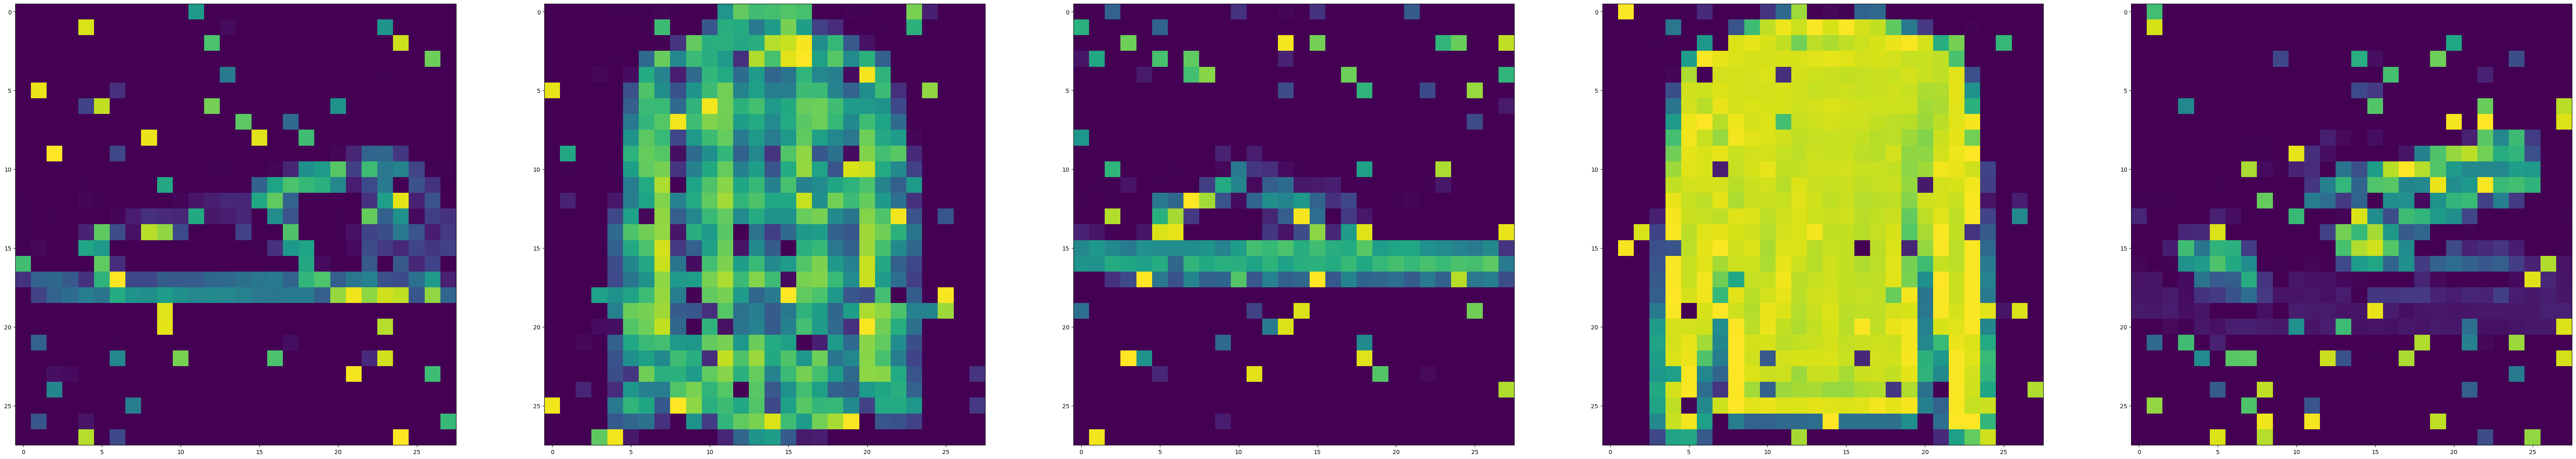

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

Lets now create the model architecture for the autoencoder. Lets understand what type of network needs to be created for this problem. 

**Encoding Architecture:**   

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.  

**Decoding Architecture:**   

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well.  Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.   



In [16]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)

latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)

output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

Here is the model summary

In [17]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,761 (194.38 KB)

 Trainable params: 49,761 (194.38 KB)

 Non-trainable params: 0 (0.00 B)

Train the model with early stopping callback. Increase the number of epochs to a higher number for better results. 

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=50, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/50
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3:16 9s/step - loss: 0.2098

2025-03-26 20:13:06.422503: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - loss: 0.1322 - val_loss: 0.0567
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0515 - val_loss: 0.0404
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0383 - val_loss: 0.0327
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0313 - val_loss: 0.0273
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0265 - val_loss: 0.0241
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0237 - val_loss: 0.0222
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0211 - val_loss: 0.0203
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0197 - val_loss: 0.0192
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0191 - val_loss: 0.0188
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0189 - val

Lets obtain the predictions of the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


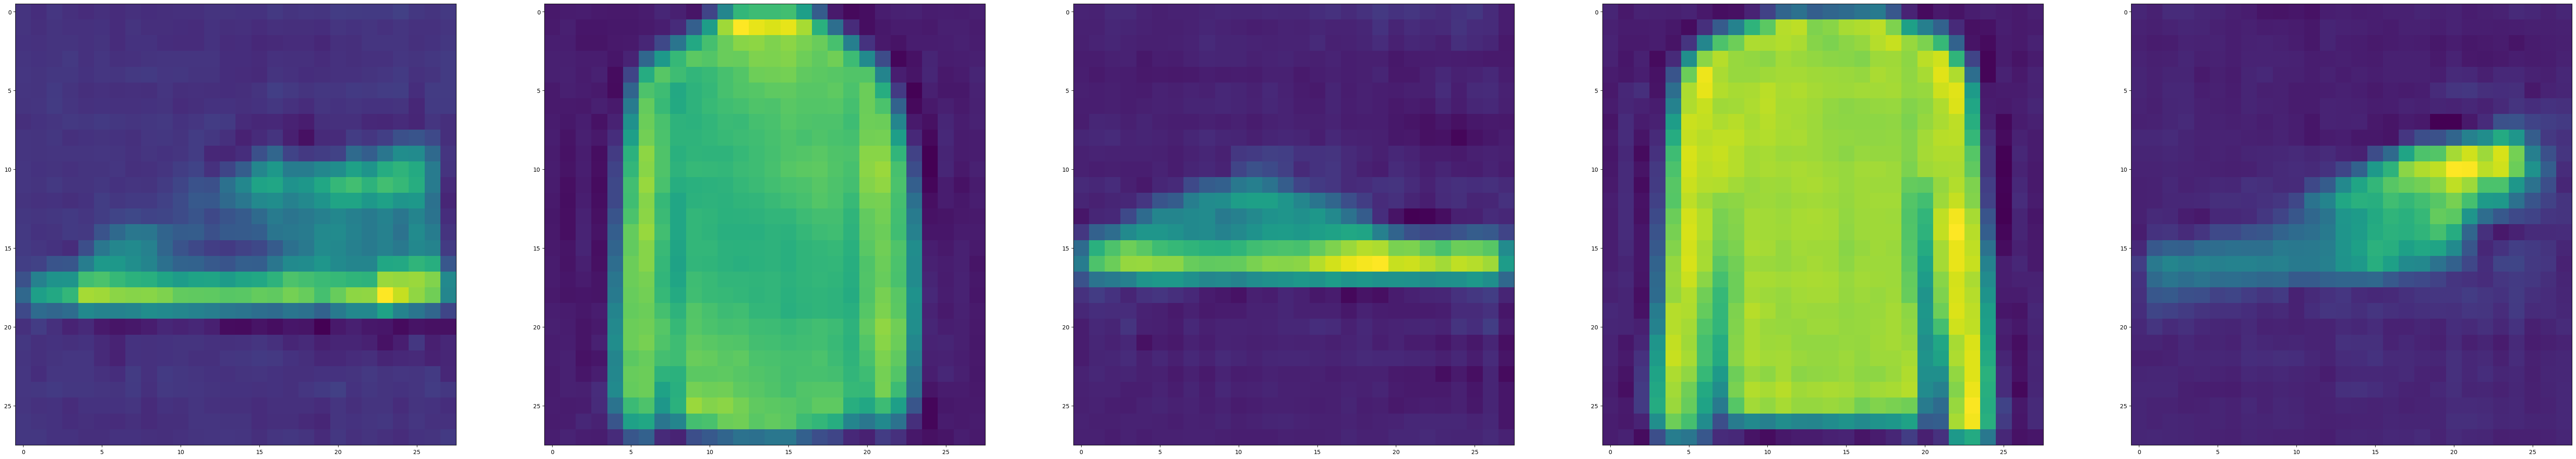

In [19]:
# Predecir sobre esas mismas imágenes
preds = model_2.predict(train_x_n[5:10])

# Visualizar predicciones
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

---

## BatchNormalization + activation(output_layer): sigmoid


In [20]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = BatchNormalization()(encoded_layer1)
encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)

encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = BatchNormalization()(encoded_layer2)
encoded_layer2 = MaxPool2D((2, 2), padding='same')(encoded_layer2)

encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
encoded_layer3 = BatchNormalization()(encoded_layer3)

latent_view = MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = BatchNormalization()(decoded_layer1)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = BatchNormalization()(decoded_layer2)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = BatchNormalization()(decoded_layer3)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)

output_layer = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(decoded_layer3)

# compile the model
model_3 = Model(input_layer, output_layer)
model_3.compile(optimizer='adam', loss='mse')

In [21]:
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,657 (197.88 KB)

 Trainable params: 50,209 (196.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

history = model_3.fit(
    train_x_n, train_x,
    epochs=200,
    batch_size=256,
    validation_data=(val_x_n, val_x),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0075 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0075 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0076 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - val_loss: 0.0076 - learning_rate: 1.0000e-07
Epoch 9/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_los

- Epoch 50/50 24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0137 - val_loss: 0.0137 (solo sigmoid)
- Epoch 50/50 24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0117 - val_loss: 0.0122 (sigmoid + batchnorm)
- Epoch 200/200 47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0086 - val_loss: 0.0428 (sigmoid + batchnorm + dropout + 1024) 
- Epoch 118/200 94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0080 - val_loss: 0.0082 - learning_rate: 1.0000e-07 (512 size)
- Epoch 173/200 94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0075 - val_loss: 0.0076 - learning_rate: 1.0000e-07 (512 size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


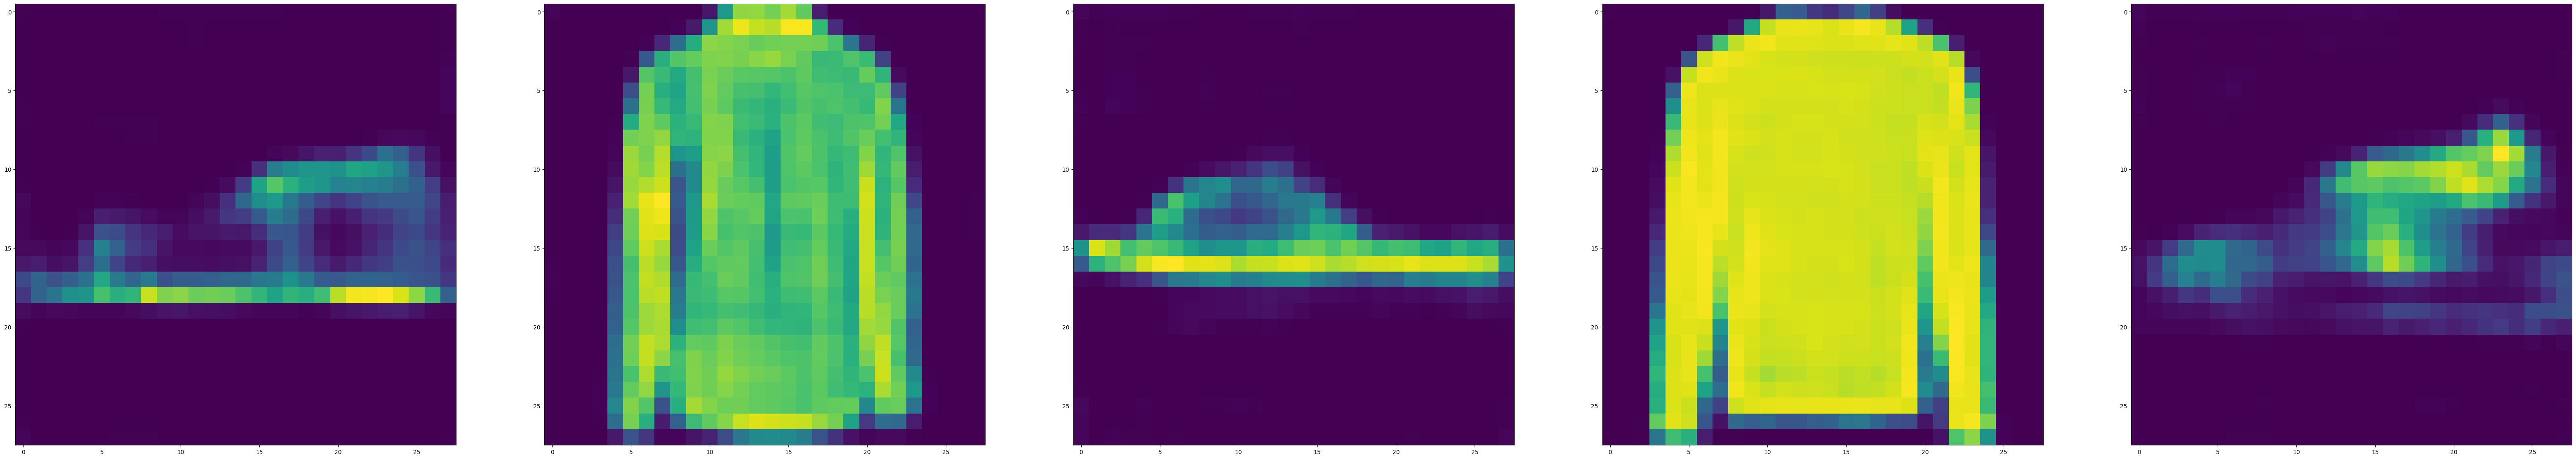

In [23]:
# Predecir sobre esas mismas imágenes
preds = model_3.predict(train_x_n[5:10])

# Visualizar predicciones
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()